In [306]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [175]:
df = pd.read_csv('PatsJags_Match_test.csv')

In [176]:
df['UTC_Datetime'] = pd.to_datetime(df['UTC_Datetime'])
df = df.sort_values('UTC_Datetime')

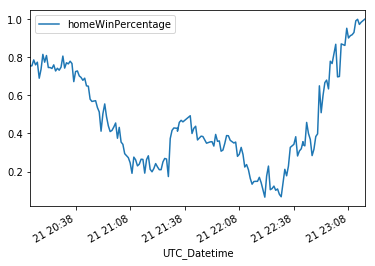

In [177]:
df.plot(x='UTC_Datetime', y='homeWinPercentage')

In [178]:
comments = pd.read_pickle('../../../data/7rzw8x_parsed_comments.pickle')

In [179]:
comments = comments[['author_flair',
                      'comment_created_utc_datetime',
                      'comment_body']].sort_values('comment_created_utc_datetime').copy()

In [180]:
comments = comments.sort_values('comment_created_utc_datetime')

In [181]:
# Loop through comments
from datetime import timedelta

only_greater = df.copy()

winpctlist = []
for row in comments.itertuples():
    mytime = row[2] + timedelta(hours=5)
    #print(mytime)
    only_greater = only_greater.loc[df['UTC_Datetime'] >= mytime]
    try:
        winpct_attime = only_greater.head(1)['homeWinPercentage'].values[0]
        #print(winpct_attime)
        winpctlist.append(winpct_attime)
    except:
        winpctlist.append('Nan')

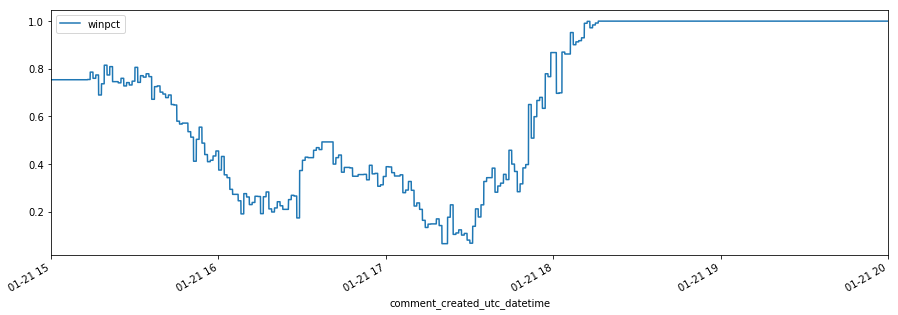

In [182]:
comments['winpct'] = winpctlist
comments['winpct'] = pd.to_numeric(comments['winpct'], errors='coerce').fillna(1)

comments.plot(x='comment_created_utc_datetime',
              y='winpct',
              xlim = (pd.to_datetime('2018-01-21 15:00'),
                      pd.to_datetime('2018-01-21 20:00')),
             figsize=(15,5))

In [184]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

def calculate_VADER(comment):
    comment = str(comment)
    ss = sid.polarity_scores(comment)
    neg = ss['neg']
    neu = ss['neu']
    pos = ss['pos']
    compound = ss['compound']
    return ss, neg, neu, pos, compound

def vader_df(df, textcol = 'text'):
    df['ss'], df['neg'], df['neu'], df['pos'], df['compound'] = \
    zip(*df[textcol].map(calculate_VADER))
    return df

In [186]:
comments = vader_df(comments, textcol='comment_body')

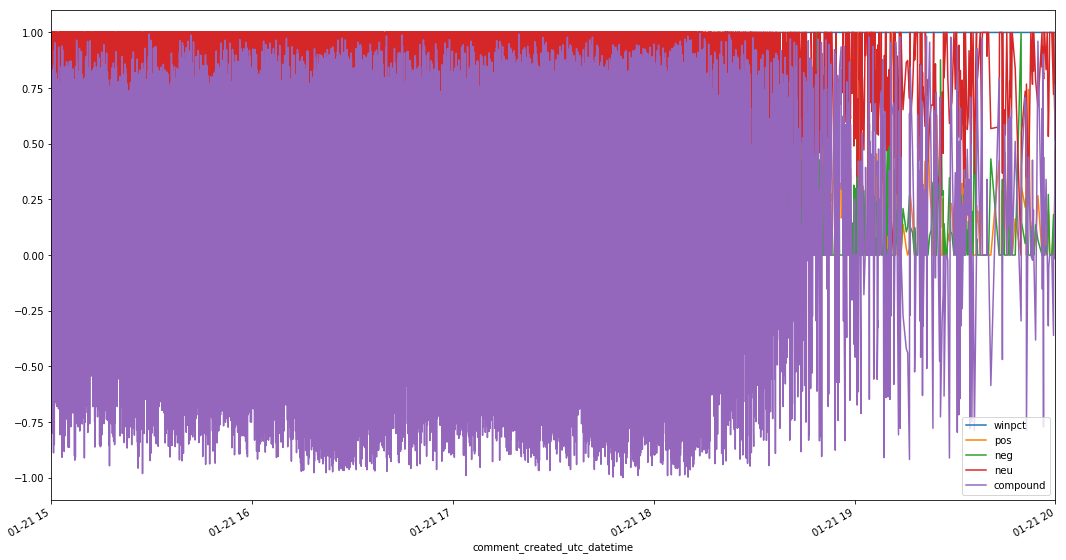

In [187]:
comments.plot(x='comment_created_utc_datetime', y=['winpct','pos','neg','neu','compound'],
              xlim = (pd.to_datetime('2018-01-21 15:00'),
                      pd.to_datetime('2018-01-21 20:00')),
             figsize=(18,10))

In [257]:
def create_rolling(df, window=200):
    df['pos_rolling'] = df['pos'].rolling(window=window).mean()
    df['neg_rolling'] = df['neg'].rolling(window=window).mean()
    df['neu_rolling'] = df['neu'].rolling(window=window).mean()
    df['compound_rolling'] = df['compound'].rolling(window=window).mean()
    return df

In [325]:
def make_plot(df, additional_title_text=''):
    df['compound_rolling'] = df['compound_rolling'] * 2
    df.plot(x='comment_created_utc_datetime', y=['winodds',
                                                 'compound_rolling'],
              xlim = (pd.to_datetime('2018-01-21 14:50'),
                      pd.to_datetime('2018-01-21 18:30')),
             figsize=(15,10),
             title='Jags Patriots Jan 21 2018 - Sentiment Analysis {}'.format(additional_title_text),
           grid=False)

    plt.axhline(0, color='black', ls='--')

    plt.show()

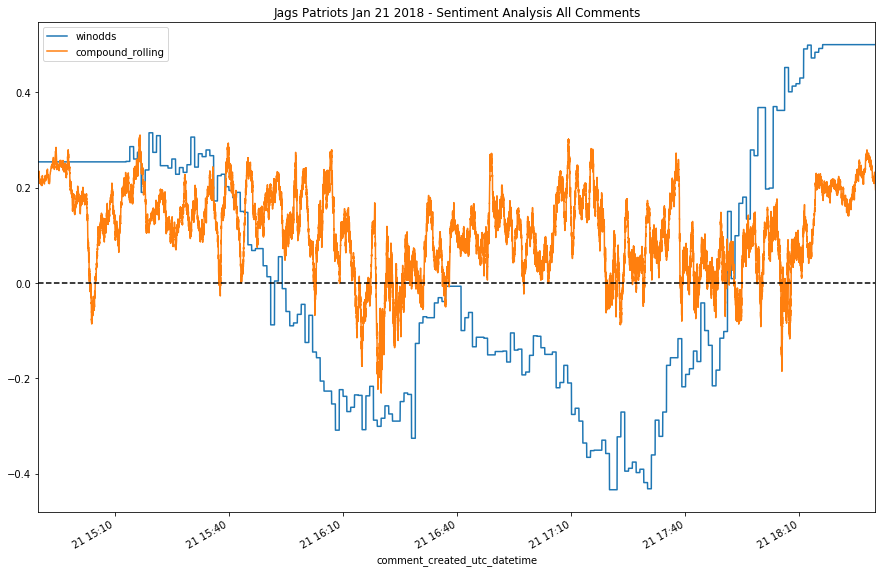

In [326]:
comments = create_rolling(comments, 300)
comments['winodds'] = (comments['winpct'] - 0.5)
make_plot(comments, additional_title_text='All Comments')

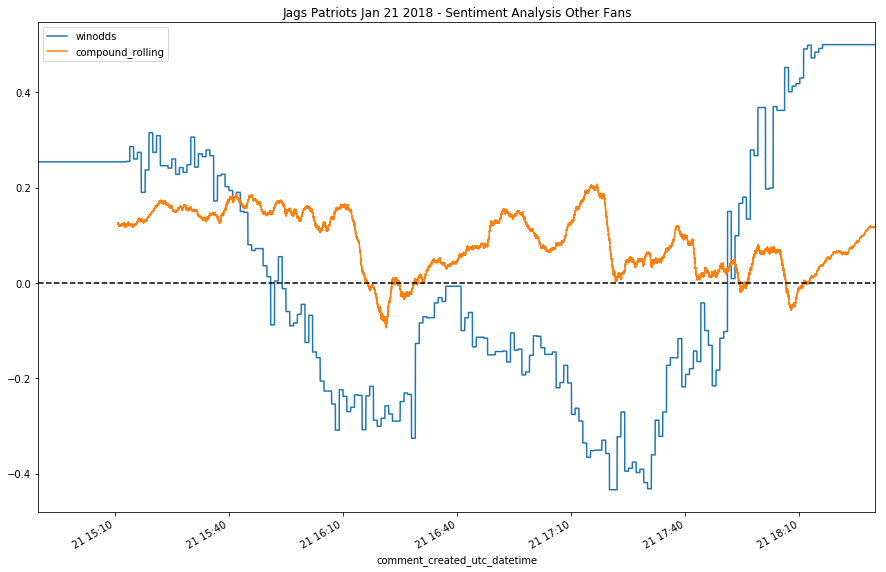

In [383]:
othercomments = comments.loc[(comments['author_flair'] != 'Patriots') &
                             (comments['author_flair'] != 'Patriots - Bandwagon') &
                            (comments['author_flair'] != 'Jaguars') &
                            (comments['author_flair'] != 'Jaguars - Bandwagon')].copy()
othercomments = create_rolling(othercomments, window=2000)
make_plot(othercomments, additional_title_text='Other Fans')

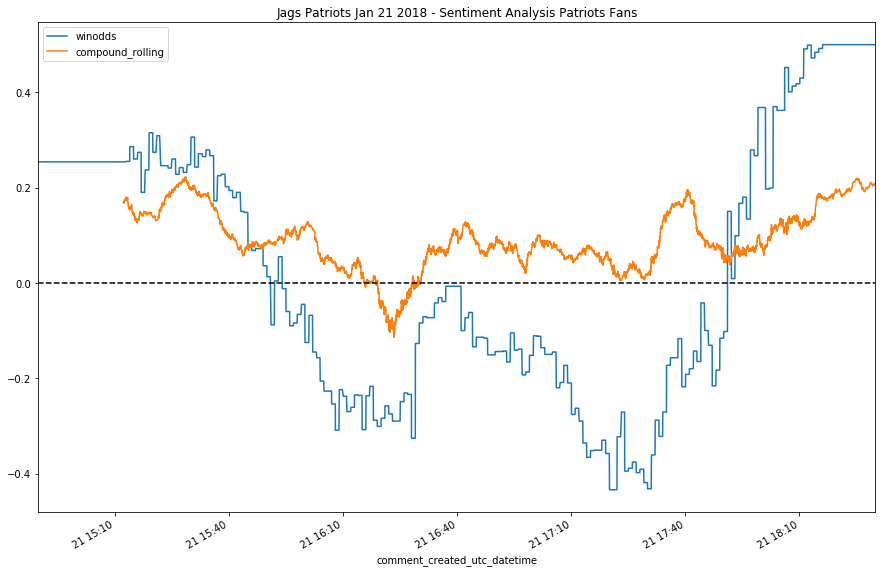

In [384]:
patscomments = comments.loc[comments['author_flair'].isin(['Patriots','Patriots - Bandwagon'])].copy()
patscomments = create_rolling(patscomments, window=600)
make_plot(patscomments, additional_title_text='Patriots Fans')

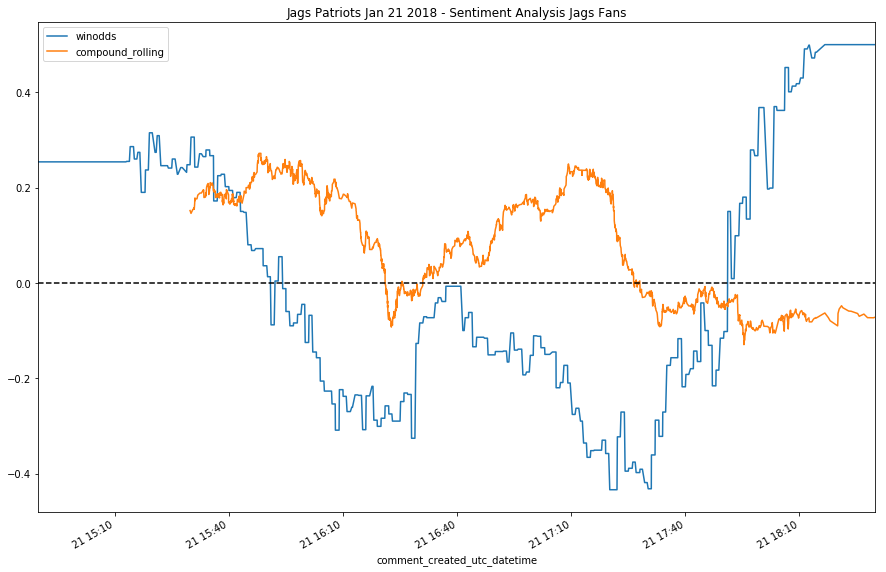

In [385]:
jagscomments = comments.loc[comments['author_flair'].isin(['Jaguars','Jaguars - Bandwagon'])].copy()
jagscomments = create_rolling(jagscomments, window=200)
make_plot(jagscomments, additional_title_text='Jags Fans')

In [331]:
print(comments.shape)
print(othercomments.shape)
print(patscomments.shape)
print(jagscomments.shape)

(66406, 14)
(54054, 14)
(10304, 14)
(2048, 14)


In [332]:
othercomments['othercomments'] = othercomments['compound_rolling']
patscomments['patscomments'] = patscomments['compound_rolling']
jagscomments['jagscomments'] = jagscomments['compound_rolling']

In [334]:
stacked = pd.concat([othercomments,patscomments,jagscomments])

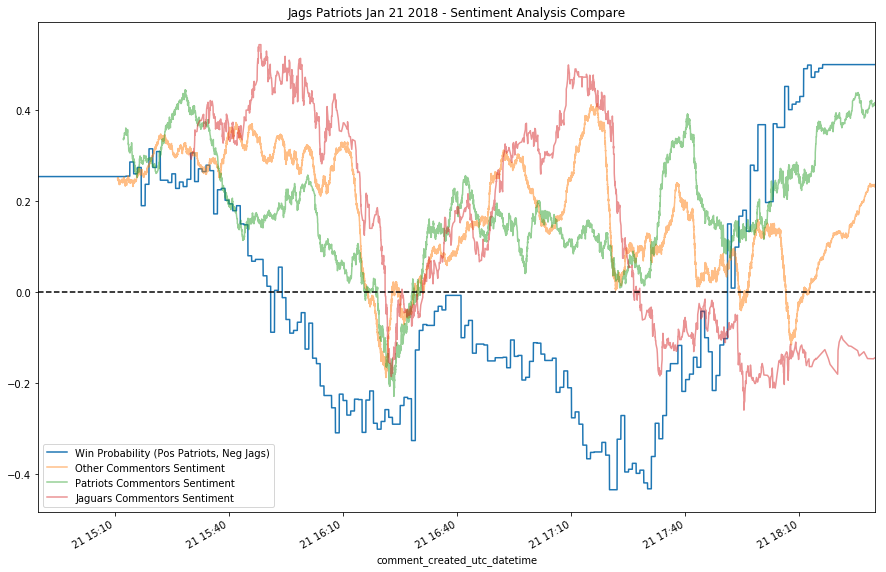

In [386]:
df1 = othercomments.copy()
df2 = patscomments.copy()
df3 = jagscomments.copy()

df1['compound_rolling'] = othercomments['compound_rolling'] * 2
df2['compound_rolling'] = patscomments['compound_rolling'] * 2
df3['compound_rolling'] = jagscomments['compound_rolling'] * 2

ax = df1.plot(x='comment_created_utc_datetime', y=['winodds'],
              xlim = (pd.to_datetime('2018-01-21 14:50'),
                      pd.to_datetime('2018-01-21 18:30')),
              figsize=(15,10),
              alpha=1)

df1.plot(x='comment_created_utc_datetime', y=[
                                             'compound_rolling'],
              xlim = (pd.to_datetime('2018-01-21 14:50'),
                      pd.to_datetime('2018-01-21 18:30')),
              figsize=(15,10),
              alpha=0.5,
        ax=ax)

df2.plot(x='comment_created_utc_datetime', 
         y=['compound_rolling'], 
         xlim = (pd.to_datetime('2018-01-21 14:50'),
                 pd.to_datetime('2018-01-21 18:30')),
         figsize=(15,10),
         alpha=0.5,
         ax=ax)

df3.plot(x='comment_created_utc_datetime', y=['compound_rolling'], label='Pats',
          xlim = (pd.to_datetime('2018-01-21 14:50'),
                  pd.to_datetime('2018-01-21 18:30')),
         figsize=(15,10),
         title='Jags Patriots Jan 21 2018 - Sentiment Analysis {}'.format(additional_title_text),
       grid=False,
        ax=ax,
        alpha=0.5)


ax.legend(["Win Probability (Pos Patriots, Neg Jags)",
           "Other Commentors Sentiment",
           "Patriots Commentors Sentiment",
          "Jaguars Commentors Sentiment"]);

#ax.annotate('point offset from data',
#            xy=(300, 400), xycoords='figure points',
#            xytext=(-15, 25), textcoords='offset points',
#            arrowprops=dict(facecolor='black', shrink=0.05),
#            horizontalalignment='right', verticalalignment='bottom')


plt.axhline(0, color='black', ls='--')

plt.show()


In [387]:
comments.to_csv('Patriots_Jags_01-21-2018-SentimentWinProb.csv')

In [419]:
for val in comments.sort_values('compound').values[0:5]:
    print('---------Compound Ranking {}---------'.format(val[8]))
    print('Fan of: ',val[0])
    print('Comment: ',val[2])

---------Compound Ranking -0.9995---------
Fan of:  49ers
Comment:  I HAVE SO MUCH FRUSTRATION I NEED TO TAKE IT OUT IN THIS THREAD FUCK FUCK FUCK FUCK NOW MYLES JACK IS OUR FUCK FUCK FUCK FUCK FUCK FUCK FUCK FUCK FUCK FUCK FUCKFUCK FUCK FUCK FUCKFUCK FUCK FUCK FUCKFUCK FUCK FUCK FUCKFUCK FUCK FUCK FUCKFUCK FUCK FUCK FUCK FUCK FUCK FUCK FUCK FUCK FUCK FUCK FUCK FUCK FUCK FUCK FUCK FUCK FUCK FUCK FUCK NOW THEY'RE ALL INJURED FUCK FUCK FUCK FUCK FUCK FUCK FUCK FUCK
---------Compound Ranking -0.9977---------
Fan of:  Lions
Comment:  Boycott SB Boycott SB Boycott SB Boycott SB Boycott SB Boycott SB Boycott SB Boycott SB Boycott SB Boycott SB Boycott SB Boycott SB Boycott SB Boycott SB Boycott SB Boycott SB Boycott SB Boycott SB Boycott SB Boycott SB Boycott SB Boycott SB Boycott SB Boycott SB Boycott SB Boycott SB Boycott SB Boycott SB Boycott SB Boycott SB Boycott SB Boycott SB Boycott SB Boycott SB Boycott SB Boycott SB Boycott SB Boycott SB Boycott SB Boycott SB Boycott SB Boycott SB Bo

In [413]:
comments

,author_flair,comment_created_utc_datetime,comment_body,winpct,ss,neg,neu,pos,compound,pos_rolling,neg_rolling,neu_rolling,compound_rolling,winodds
11701,Colts,2018-01-21 14:35:18,Finally,0.754,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,NaN,NaN,NaN,NaN,0.254
10866,Rams,2018-01-21 14:35:21,Ugh let’s go PATRIOTS\n\nI feel dirty,0.754,"{'neg': 0.588, 'neu': 0.412, 'pos': 0.0, 'comp...",0.588,0.412,0.000,-0.6908,NaN,NaN,NaN,NaN,0.254
50,Eagles - Bandwagon,2018-01-21 14:35:26,http://imgur.com/FGmBwZq,0.754,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,NaN,NaN,NaN,NaN,0.254
8010,Patriots,2018-01-21 14:35:26,Go Patriots!,0.754,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,NaN,NaN,NaN,NaN,0.254
2148,Chiefs,2018-01-21 14:35:28,Over under on Brady hand mentions?,0.754,"{'neg': 0.0, 'neu': 0.61, 'pos': 0.39, 'compou...",0.000,0.610,0.390,0.4939,NaN,NaN,NaN,NaN,0.254
11702,Patriots,2018-01-21 14:35:29,go pats,0.754,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,NaN,NaN,NaN,NaN,0.254
27579,None,2018-01-21 14:35:30,Het the fuck outta the way,0.754,"{'neg': 0.412, 'neu': 0.588, 'pos': 0.0, 'comp...",0.412,0.588,0.000,-0.5423,NaN,NaN,NaN,NaN,0.254
46,Ravens,2018-01-21 14:35:32,Please Jacksonville. You’re our only hope. (Fo...,0.754,"{'neg': 0.0, 'neu': 0.606, 'pos': 0.394, 'comp...",0.000,0.606,0.394,0.6369,NaN,NaN,NaN,NaN,0.254
16650,Patriots,2018-01-21 14:35:33,Leggo.,0.754,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,NaN,NaN,NaN,NaN,0.254
17683,Jets,2018-01-21 14:35:34,Jaguars fans (for today only) Unite!,0.754,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,NaN,NaN,NaN,NaN,0.254


In [418]:
for val in comments.sort_values('compound').values[-5:]:
    print('---------Compound Ranking {}---------'.format(val[8]))
    print('Fan of: ',val[0])
    print('Comment: ',val[2])

---------Compound Ranking 0.9912---------
Fan of:  None
Comment:  No surprise there.  The Pats always win.  They. Always. Win.  Another year, another Patriots Super Bowl victory.  It doesn't matter who they play.  I remember how neat it used to be when different teams would win championships.  It kind of made it interesting.  It's cool though, at least it makes it easier to bet on who will definitely, absolutely, without question win the Super Bowl each year.
---------Compound Ranking 0.9927---------
Fan of:  Dolphins
Comment:  YES! YES! YES! YES! YES! YES! YES! YES! YES! YES! YES! YES! YES! YES! YES! YES! YES! YES! 
---------Compound Ranking 0.993---------
Fan of:  Colts
Comment:  Someone can chime in but I'm beginning to think that a lot of good actors are like good QBs; if you're lucky enough, you'll star in a 4-6 season series, or 2 of 'em -- like good QBs are lucky enough to win 1-2 in their careers (Jon Hamm, Brian Cranston vs Big Ben, Peyton Manning, Rodgers, etc), and that's co